This file just tests the bell state measurement function in Trajectree. Due to the integral nature of this function in all measurements, it is important that this works correctly. We will be trying to charecterize a perfect bell state using the function. 

In [1]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.devices import ry, rx, rz, global_phase, generalized_mode_mixer_unitary
from trajectree.fock_optics.measurement import bell_state_measurement
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import single_mode_bosonic_noise_channels, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import copy
from IPython.display import HTML
from IPython.display import Image

In [2]:
generalized_mode_mixer_unitary(np.pi, 0, 0, 0, 2)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [3]:
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) - np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi, psi.site_tags



In [4]:
N = 3
num_modes = 4
efficiency = 1
error_tolerance = 1e-10
num_simulations = 1

bsm_det_effs = [0.5,0.5]
bsm_dark_counts_gain = [1+1e-6,1+1e-6]
# bsm_measurements = {0:(2,3), 1:(0,1)}
bsm_measurements = {0:(0,2), 1:(1,3)}


In [5]:
psi, site_tags = create_perfect_bell_state(N)

read_quantum_state(psi, N, num_states = 2)

Corresponding Basis terms:
1H0V_B 1H0V_A - 10 - [-0.70710678+0.j]
0H1V_B 0H1V_A - 30 - [0.70710678+0.j]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

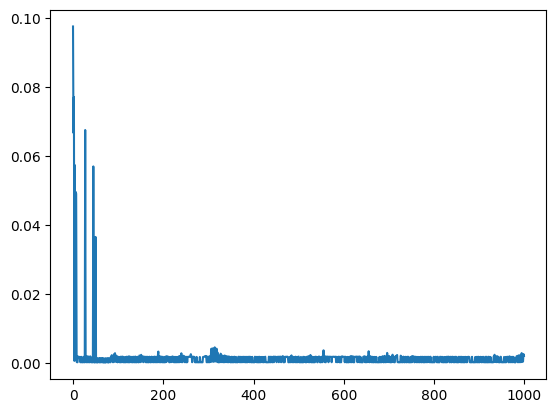

In [10]:
import time
quantum_channel_list = []

phase_flip_ops = [sp.csr_matrix(global_phase(0, N, return_unitary = True, site1 = 0, site2 = 1, total_sites = 2))]
quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1), phase_flip_ops), name = "first_kraus"))

BSM_quantum_channels = bell_state_measurement(None, N, site_tags, num_modes, bsm_det_effs, bsm_dark_counts_gain, error_tolerance, beamsplitters = [[0,2],[1,3]], measurements = bsm_measurements, pnr = False, use_trajectory = True, return_MPOs = True, compress=True, contract=True)
quantum_channel_list.extend(BSM_quantum_channels)

evaluator = trajectory_evaluator(quantum_channel_list)

times = []
for i in range(1000):
    start = time.time()
    print(i)
    # psi_iter = evaluator.perform_simulation(psi, error_tolerance, trajectree_indices = [0,4,0,0,0], normalize = True)
    psi_iter = evaluator.perform_simulation(psi, error_tolerance, normalize = True)
    duration = time.time() - start
    times.append(duration)

    # evaluator.graph.show()
    
# read_quantum_state(psi_iter, N, num_states = 2)
plt.plot(times)
# psi_iter.normalize()
# coincidence_HH_ops_list

In [7]:
import io
evaluator.graph.show()
evaluator.graph.to_dict()
# display(Image(dot_data.pipe(format='png')))

()
└── (0,)
    ├── (0, 0)
    │   ├── (0, 0, 0)
    │   │   └── (0, 0, 0, 0)
    │   ├── (0, 0, 1)
    │   │   └── (0, 0, 1, 0)
    │   ├── (0, 0, 2)
    │   │   └── (0, 0, 2, 0)
    │   ├── (0, 0, 3)
    │   │   └── (0, 0, 3, 0)
    │   └── (0, 0, 6)
    │       └── (0, 0, 6, 0)
    ├── (0, 1)
    │   └── (0, 1, 0)
    │       └── (0, 1, 0, 0)
    ├── (0, 2)
    │   └── (0, 2, 0)
    │       └── (0, 2, 0, 0)
    ├── (0, 3)
    │   └── (0, 3, 0)
    │       └── (0, 3, 0, 0)
    └── (0, 6)
        └── (0, 6, 0)
            └── (0, 6, 0, 0)



{'()': {'children': [{'(0,)': {'children': [{'(0, 0)': {'children': [{'(0, 0, 0)': {'children': ['(0, 0, 0, 0)']}},
         {'(0, 0, 1)': {'children': ['(0, 0, 1, 0)']}},
         {'(0, 0, 2)': {'children': ['(0, 0, 2, 0)']}},
         {'(0, 0, 3)': {'children': ['(0, 0, 3, 0)']}},
         {'(0, 0, 6)': {'children': ['(0, 0, 6, 0)']}}]}},
      {'(0, 1)': {'children': [{'(0, 1, 0)': {'children': ['(0, 1, 0, 0)']}}]}},
      {'(0, 2)': {'children': [{'(0, 2, 0)': {'children': ['(0, 2, 0, 0)']}}]}},
      {'(0, 3)': {'children': [{'(0, 3, 0)': {'children': ['(0, 3, 0, 0)']}}]}},
      {'(0, 6)': {'children': [{'(0, 6, 0)': {'children': ['(0, 6, 0, 0)']}}]}}]}}]}}

In [8]:
for qc in quantum_channel_list:
    print(qc.name)


first_kraus
beam splitter
beam splitter
detector inefficiency
detector inefficiency
dark counts
dark counts
Det POVM
Det POVM
Det POVM
Det POVM
